# Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import time
import string
import re
from collections import Counter
import random
from typing import *
import csv

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import from Preprocessing

In this first part are imported all the preprocessed data from the **preprocessing** notebook.

In [5]:
def read_dataset(data_path: str) -> (List[List[str]], List[List[str]]):
    """
    Returns
    -------
        Two lists of lists containing sentences and labels respectively.
        
    Parameters
    ----------
    data_path: str
        Data path of the dataset.
    """
    
    sentences_list = []
    labels_list = []
    
    with open(data_path, "r", encoding='utf-8') as f:
        for line in f:
            row = line.strip()
            
            if row.startswith("#\tid"): # New sentence
                sentence = []
                labels = []
                
            elif row == "": # End of the sentence
                sentences_list.append(sentence)
                labels_list.append(labels)
            
            else: # Words of a sentence
                word, label = row.split('\t')
                
                sentence.append(word)
                labels.append(label)
   
    return sentences_list, labels_list

In [6]:
# Utility function taken from the 'evaluate.py' script
def flat_list(l: List[List[Any]]) -> List[Any]:
    """
    Returns
    -------
        A single list containing all elements that
        were in the input list.
        
    Parameters
    ----------
    l: List[List[Any]]
        A list of lists of any type
    """
    return [_e for e in l for _e in e]

In [7]:
def freq_most_common_tokens(dataset_text: List[List[str]], n: int = 20) -> dict:
    """
    Returns
    -------
        The first n common tokens and their frequencies, where the tokens are
        retrieved from the list 'dataset_text'.
        
    Parameters
    ----------
    dataset_text: List[List[str]]
        A list of lists of strings. 
        In this case each nested list is a sentence.
    
    n: int
        Indicates how many tokens to consider.
        If it is a negative number, 
        the function returns the frequencies of all the tokens in the dataset.
    
    """
    # The input is flattened
    tokens = flat_list(dataset_text)  

    # If negative number, return the frequency of all the tokens
    if n <= -1:
        return dict(Counter(tokens).most_common(len(Counter(tokens))))
    else:
        return dict(Counter(tokens).most_common(n))

In [8]:
train_pos_dep_path = "../../data/train_pos_dep.tsv"
valid_pos_dep_path = "../../data/valid_pos_dep.tsv"

In [9]:
def read_dataset_pos_dep(data_path: str) -> (List[List[str]], List[List[str]], List[List[str]], List[List[str]]):
    """
    Returns
    -------
        Four lists of lists containing sentences and POS labels,
        headwords labels and dependencies labels respectively.
        
    Parameters
    ----------
    data_path: str
        Data path of the dataset.
    """

    sentences_list = []
    labels_list = []
    heads_list = []
    dependencies_list = []
    
    with open(data_path, "r", encoding='utf-8') as f:
        for line in f:
            row = line.strip()
            
            if row.startswith("#\tid"): # New sentence
                sentence = []
                labels = []
                dependencies = []
                heads = []
                
            elif row == "": # End of the sentence
                sentences_list.append(sentence)
                labels_list.append(labels)
                heads_list.append(heads)
                dependencies_list.append(dependencies)
            
            else: # Words of a sentence
                word, label, head, dep = row.split('\t')
                
                sentence.append(word)
                labels.append(label)
                heads.append(head)
                dependencies.append(dep)
   
    return sentences_list, labels_list, heads_list, dependencies_list

In [10]:
_, train_pos, train_heads, train_dep = read_dataset_pos_dep(train_pos_dep_path)
_, valid_pos, valid_heads, valid_dep = read_dataset_pos_dep(valid_pos_dep_path)

In [12]:
train_clean_path = "../../data/train_clean.tsv"
valid_clean_path = "../../data/valid_clean.tsv"

In [13]:
train_sentences, train_labels = read_dataset(train_clean_path)
valid_sentences, valid_labels = read_dataset(valid_clean_path)

In [15]:
vocab_path = "../../data/vocab.tsv"

In [16]:
pad_token = "<PAD>"
unk_token = "<UNK>"

In [17]:
def read_vocab(path: str) -> dict:
    """
    Returns
    -------
        A dictionary that maps tokens to integers.
        
    Parameters
    ----------
    path: str
        Data path of the dictionary.
    """
    vocab = {}
    with open(path, 'r', newline="", encoding='utf-8') as f:
        for line in f:
            line = line.strip().split('\t')
            vocab[line[0]] = int(line[1])
    return vocab

In [18]:
vocab = read_vocab(vocab_path)

In [19]:
len(vocab)

20000

In [21]:
char_vocab_path = "../../data/char_vocab.tsv"

In [22]:
char_vocab = read_vocab(char_vocab_path)

In [23]:
len(char_vocab)

53

In [24]:
dep_vocab_path = "../../data/dep_vocab.tsv"

In [25]:
dep_vocab = read_vocab(dep_vocab_path)

In [26]:
len(dep_vocab)

47

In [27]:
def assign_unique_idx(labels_list: List[List[str]], pad_token: str) -> (dict, dict):
    """
    Returns
    -------
        Two dictionaries. The first one is a map
        from labels to integers; the second one
        is the reversed map.
        
    Parameters
    ----------
    labels_list: List[List[str]]
        A list of lists of strings. 
        In this case each nested list is a sentence,
        containing labels.
        
    pad_token: str
         String which identifies the padding token.
    """
    labels = freq_most_common_tokens(labels_list, n=-1)
    lab2idx = {label: idx+1 for idx, label in enumerate(labels)}
    lab2idx[pad_token] = 0 # The padding token is associated to the first position
    idx2lab = {idx: label for label, idx in lab2idx.items()} 
    
    return lab2idx, idx2lab

In [28]:
lab2idx, idx2lab = assign_unique_idx(train_labels, pad_token)

In [29]:
pos2idx, pos2lab = assign_unique_idx(train_pos, pad_token)

# Pretrained Word Embedding

## Word2Vec

In [ ]:
from gensim.models import *
from gensim.models.word2vec import *

In [27]:
w2v_path = '../../model/pretrained/load_embeddings/pre_w2v.pth'

In [29]:
pretrained_embeddings = torch.load(w2v_path)

In [ ]:
pretrained_embeddings.shape

torch.Size([10000, 300])

## GloVe

In [30]:
pretrained_glove_path = "../../model/pretrained/load_embeddings/pre_glove.pth"

In [31]:
glove_pretrained_embeddings = torch.load(pretrained_glove_path)

In [32]:
glove_pretrained_embeddings.shape

torch.Size([20000, 100])

## Fastext

In [33]:
pretrained_fast_path = "../../model/pretrained/load_embeddings/pre_fast.pth"

In [34]:
fast_pretrained_embeddings = torch.load(pretrained_fast_path)

In [35]:
fast_pretrained_embeddings.shape

torch.Size([20000, 300])

# Dataset

In [36]:
class NER_Dataset(Dataset):
    """
    Parameters
    ----------
    sentences: List[List[str]]
        A list of lists of strings where each nested list represents a sentence.
        
    sentences_labels: List[List[str]]
        A list of lists of strings where each nested list represents a sentence,
        containing the labels of the tokens.
    """
    def __init__(self, sentences: List[List[str]], sentences_labels: List[List[str]]):

        assert len(sentences) == len(sentences_labels), \
                "Inputs must be of the same length"
        
        self.sentences = sentences
        self.labels = sentences_labels
        
        self.sentences_lengths = [len(s) for s in sentences]
  
        self.Y = self._from_sequence_to_idx(sentences_labels, lab2idx)
        self.X = self._from_sequence_to_idx(sentences, vocab, unk_token)
     
    
    def _from_sequence_to_idx(self, sequences_list: List[List[str]],
                              vocab: dict, unk_token: str = None) -> List[List[int]]:
        """
        Returns
        -------
            A list of lists of int built by replacing 
            each token with its corresponding id in the vocabulary.
            This is a general function so it works also for labels.
            
        Parameters
        ----------
        sequences_list: List[List[str]]
            A list of lists of strings where each nested list represents a sentence.
            
        vocab: dict
            The map that associates to each token an unique number.

        unk_token: str
            The OOV token.
        """
        
        sequences_idx = []
        
        if unk_token is not None: # For words
            for sentence in sequences_list:
                sequences_idx.append([vocab.get(token, vocab[unk_token]) for token in sentence])
        else: # For labels
            for sentence in sequences_list:
                sequences_idx.append([vocab.get(token) for token in sentence])
        
        return sequences_idx

    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        return self.Y[idx], self.X[idx], self.sentences_lengths[idx]

In [37]:
train_dataset = NER_Dataset(train_sentences, train_labels)
valid_dataset = NER_Dataset(valid_sentences, valid_labels)

In [38]:
def pad_sequence(sequence: List[Any], max_length: int, pad_token: str) -> List[Any]:
    """
    Returns
    -------
        A list padded with the 'pad_token' value until 
        it is 'max_length' long. 

    Parameters
    ----------
    sequence: List[Any]
        The list to be padded. 

    max_length: int
        The length of the output list.

    pad_token: str
        The Padding value.
    """
    padded_sequence = [pad_token] * max_length

    for i, token in enumerate(sequence):
        padded_sequence[i] = token

    return padded_sequence

In [39]:
def collate_batch(batch):
    """
    Returns
    -------
        Tensors of the zipped lists in input, sorted in
        descending order by sentences length.
        (The ordering can be useful if 'pack_padded_sequence'
        will be used)
        
    Parameters
    ----------
        batch
            A zipped python object containing features and labels.
    
    """
    labels_list = []
    features_list = []

    # Retrieve the features
    labels, features, sentences_lengths = zip(*batch)
    
    # Sort in descending order the sentences by length
    sorted_batch = sorted(zip(labels, features, sentences_lengths), 
                          key=lambda p: len(p[0]), reverse=True)
    labels, features, sentences_lengths = zip(*sorted_batch)
    

    max_length_in_batch = np.max(sentences_lengths)
    
    # Pad sentences and labels to the length of the longest sequence in the batch
    for idx, feature in enumerate(features):
        features_list.append(pad_sequence(feature, max_length_in_batch, vocab[pad_token]))
        labels_list.append(pad_sequence(labels[idx], max_length_in_batch, vocab[pad_token]))
      

    labels_tensor = torch.LongTensor(labels_list).to(device)
    features_tensor = torch.LongTensor(features_list).to(device)

    return labels_tensor, features_tensor, sentences_lengths

This is the NER module that gives the best results. From the input it retrieves both FastText and GloVe pretrained embeddings, concatenates them and passes the result as input to the LSTM. Before, the classification layer, the LSTM output is passed through a fully connected layer.

In [40]:
from TorchCRF import CRF
class NER_Classifier(nn.Module):
    def __init__(self, h_params):
        super().__init__()
        
        # Fasttext
        self.fast_embeddings = self._from_pretrained_embeddings(h_params['fast_embeddings'],
                                                               h_params['vocab_size'],
                                                               h_params['fast_embed_dim'],
                                                               freeze=h_params['freeze_fast'])
            

        # Glove
        self.glove_embeddings = self._from_pretrained_embeddings(h_params['glove_embeddings'],
                                                                 h_params['vocab_size'],
                                                                 h_params['glove_embed_dim'],
                                                                 freeze=h_params['freeze_glove'])
        
        lstm_input_dim = h_params['fast_embed_dim'] + h_params['glove_embed_dim']
        
        # LSTM
        self.lstm = nn.LSTM(lstm_input_dim, 
                            h_params['lstm_hidden_dim'], 
                            bidirectional=h_params['bidirectional'],
                            num_layers=h_params['num_layers'],
                            dropout=h_params['dropout'] if h_params['num_layers'] > 1 else 0,
                            batch_first=True)
        
        
        lstm_output_dim = h_params['lstm_hidden_dim'] if h_params['bidirectional'] is False \
                            else h_params['lstm_hidden_dim'] * 2
        

        self.dropout = nn.Dropout(h_params['dropout'])  

        self.concat = nn.Linear(lstm_output_dim, lstm_output_dim)

        self.classifier = nn.Linear(lstm_output_dim, h_params['num_classes'])
        
        self.relu = nn.LeakyReLU()
        
        if h_params['use_crf']:
            self.crf = CRF(h_params['num_classes'])

        self._init_linear_weights()
        
        
    def forward(self, x, x_lengths):
        x_fast = self.fast_embeddings(x)
        x_glove = self.glove_embeddings(x)
    
        # Concatenate the word embeddings
        x = torch.cat((x_fast, x_glove), dim=2)  
        x = self.dropout(x)
        
        x, _ = self.lstm(x)
        x = self.relu(x)
        
        x = self.concat(x)
        x = self.relu(x)

        output = self.classifier(x)

        return output


    def _from_pretrained_embeddings(self, pretrained_embeddings: torch.Tensor, 
                                    vocab_size: int, embed_dim: int, 
                                    freeze: bool) -> torch.Tensor:
        """
        Returns
        -------
            Pretrained embeddings from input.
            
        Parameters
        ----------
        pretrained_embeddings: torch.Tensor
            Embeddings to be loaded.
            
        vocab_size: int
            Size of the dictionary of embeddings.
            
        embed_dim: int
            Size of each embedding vector.
            
        freeze: bool
            If True the embeddings weights will be not updated
            during training.
        
        """
        
        embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # Get emebeddings from pretrained ones
        embeddings.weight.data.copy_(pretrained_embeddings)
        
        # Freeze embeddings
        embeddings.weight.requires_grad = not freeze 
        
        return embeddings
    
    def _init_linear_weights(self):
        initrange = 0.5

        self.concat.weight.data.uniform_(-initrange, initrange)
        self.concat.bias.data.zero_()

        self.classifier.weight.data.uniform_(-initrange, initrange)
        self.classifier.bias.data.zero_()

# Training

In [41]:
def train(model: nn.Module, dataloader: DataLoader, h_params: dict, 
          optimizer: torch.optim, criterion: torch.nn, grad_clipping:float):
    model.train()    
    running_loss = 0.0
    viterbi_pred = None
    
    for idx, (labels, features, sentences_lengths) in enumerate(dataloader): 
        # Empty gradients
        optimizer.zero_grad()

        # Forward
        predicted_labels = model(features, sentences_lengths)

        
        if h_params['use_crf']:
            # Mask for extracting the actual length of the predictions,
            # as padding must be ignored
            mask = (labels != lab2idx[pad_token])
            
            log_likelihood = model.crf(predicted_labels, labels, mask=mask)
            # Predictions
            viterbi_pred = flat_list(model.crf.viterbi_decode(predicted_labels, mask=mask))        
                
                
            # The log likelihood is not "normalized" 
            # (It is not reduced, for instance by mean, and it is negative)
            loss = torch.mean(log_likelihood) * -1
            
        else:
            predicted_labels = predicted_labels.view(-1, predicted_labels.shape[-1])
            labels = labels.view(-1)
            loss = criterion(predicted_labels, labels)
            

         # Backward  
        loss.backward()
        
        # Gradient Clipping to prevent exploding gradients
        if grad_clipping is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clipping)
        
        # Update weights 
        optimizer.step()
        
        running_loss += loss.item()

    # Loss at the end of the epoch 
    return running_loss/len(dataloader), _

In [42]:
def evaluate(model: nn.Module, dataloader: DataLoader, 
             h_params: dict, criterion: torch.nn):
    model.eval()
    valid_loss = 0.0
    f1_score = 0.0
    viterbi_pred = None
    
    with torch.no_grad():
        for idx, (labels, features, sentences_lengths) in enumerate(dataloader):
            predicted_labels = model(features, sentences_lengths)
            
            if h_params['use_crf']:
                # Mask for extracting the actual length of the predictions,
                # as padding must be ignored
                mask = (labels != lab2idx[pad_token])
                log_likelihood = model.crf(predicted_labels, labels, mask=mask) 
                
                viterbi_pred = flat_list(model.crf.viterbi_decode(predicted_labels, mask=mask))                        
                
                # The log likelihood is not "normalized" 
                # (It is not reduced, for instance by mean, and it is negative)
                loss = torch.mean(log_likelihood) * -1

                predicted_labels = predicted_labels.view(-1, predicted_labels.shape[-1])
                labels = labels.view(-1)
                

            else:
                predicted_labels = predicted_labels.view(-1, predicted_labels.shape[-1])
                labels = labels.view(-1)
                loss = criterion(predicted_labels, labels)
                
               
            valid_loss += loss.item()
            f1_score += compute_score(predicted_labels, labels, viterbi_pred)
            
    return valid_loss/len(dataloader), f1_score/len(dataloader)

In [43]:
from seqeval.metrics import f1_score
def compute_score(predictions: torch.Tensor, labels: torch.Tensor, viterbi_pred: List[int] = None):
    """
    Returns
    -------
        The F1 score from predictions and ground truths.
        
    Parameters
    ----------
    predictions: torch.Tensor
        Predictions. 
    
    labels: torch.Tensor
        Ground truths.
    
    viterbi_pred: List[int]
        If it is not None, it the list of predictions
        computed by the viterbi decoding algorithm.
    
    """
    y_true_list = []
    y_pred_list = []
    
    if pad_token != None:
        # Mask for extracting the actual length of the predictions,
        # as padding must be ignored
        mask = labels != lab2idx[pad_token]
        
    else:
        mask = labels != -1
    
   
    labels = labels[mask].tolist() 
    y_true = [idx2lab[l] for l in labels]
    y_true_list.append(y_true)
    
    
    if viterbi_pred is not None:
        y_pred = [idx2lab[l] for l in viterbi_pred]
        y_pred_list.append(y_pred)
        
    else:  
        predictions = predictions.argmax(1)
        predictions = predictions[mask].tolist()
    
        y_pred = [idx2lab[l] for l in predictions]
        y_pred_list.append(y_pred)

    
    return f1_score(y_true_list, y_pred_list, average='macro')

In `train_model` the early stooping part is taken from the **NLP Notebook #5**.

In [44]:
def train_model(
    model: nn.Module,
    train_dataloader: DataLoader,
    valid_dataloader: DataLoader,
    h_params: dict,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn,
    scheduler: torch.optim.lr_scheduler,
    grad_clipping: float,
    epochs: int,
    early_stopping: bool = False,
    early_stopping_mode: str = 'max',
    early_stopping_patience: int = 0,
):
    train_losses = []
    valid_losses = []
    valid_f1_scores = []
    patience_counter = 0
    
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        
        # Train
        train_loss, _ = train(model, train_dataloader, h_params,
                              optimizer, criterion, grad_clipping)
        train_losses.append(train_loss)
        
        # Evaluate
        valid_loss, valid_f1_score = evaluate(model, valid_dataloader,
                                             h_params, criterion)
        valid_losses.append(valid_loss)
        valid_f1_scores.append(valid_f1_score)
        
        
        
        # If the model starts overfitting, then the learning rate is decreased
        # if valid_loss is not None and train_loss < valid_loss:
        if scheduler is not None:
            print(f"LR: {scheduler.get_last_lr()[0]:.6f}")
            scheduler.step()
    
        print('-' * 100)
        epoch_time = time.time() - epoch_start_time
        print(f'| epoch {epoch:3d}/{epochs:d} | time: {epoch_time:5.2f}s | ' \
            f'train_loss: {train_loss:.3f} | valid_loss: {valid_loss:.3f} | valid_f1_score: {valid_f1_score:.3f}')
            
        print('-' * 100)
        
        if valid_f1_score < 0.1:
            print("Too bad...")
            return
        
        if early_stopping and len(valid_f1_scores) >= 2:

#             stop = early_stopping_mode == 'min' and epoch > 0 and valid_f1_scores[-1] > valid_f1_scores[-2]
            stop = early_stopping_mode == 'max' and epoch > 0 and valid_f1_scores[-1] < valid_f1_scores[-2]
            if stop:
                if patience_counter >= early_stopping_patience:
                    print('Early stop.')
                    break
                else:
                    print('-- Patience.\n')
                    patience_counter += 1
        
        histories = {
            "train_losses": train_losses,
            "valid_losses": valid_losses,
            "valid_f1_scores": valid_f1_scores
        }
    return histories

In [45]:
# Hyperparameters
h_params = {
    'vocab_size': len(vocab),
    'fast_embed_dim': 300,
    'freeze_fast': True,
    'glove_embed_dim': 100,
    'freeze_glove': False,
    'lstm_hidden_dim': 512, 
    'num_classes': len(lab2idx),
    'fast_embeddings': fast_pretrained_embeddings,
    'glove_embeddings': glove_pretrained_embeddings,
    'bidirectional': True,
    'num_layers': 3,
    'dropout': 0.4,
    'use_crf': True,
}

epochs = 12 # number of epochs
lr = 0.003 # learning rate
bacth_size = 256  # batch size 
grad_clipping = 0.7 # for clipping gradients  

model = NER_Classifier(h_params).to(device)
print(model)

    
                                            # ignore the padding class
criterion = torch.nn.CrossEntropyLoss(ignore_index=lab2idx[pad_token]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# scheduler = None
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)          
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 7,], gamma=0.2)


train_dataloader = DataLoader(train_dataset, batch_size=bacth_size, 
                              collate_fn=collate_batch, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=bacth_size, 
                              collate_fn=collate_batch, shuffle=False)

histories = train_model(model, train_dataloader, valid_dataloader, h_params, 
                        optimizer, criterion, scheduler, grad_clipping, epochs,
                        early_stopping=True, early_stopping_mode="max", 
                        early_stopping_patience=2)

NER_Classifier(
  (fast_embeddings): Embedding(20000, 300, padding_idx=0)
  (glove_embeddings): Embedding(20000, 100, padding_idx=0)
  (lstm): LSTM(400, 512, num_layers=3, batch_first=True, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (concat): Linear(in_features=1024, out_features=1024, bias=True)
  (classifier): Linear(in_features=1024, out_features=14, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (crf): CRF()
)
LR: 0.003000
----------------------------------------------------------------------------------------------------
| epoch   1/12 | time: 31.22s | train_loss: 35.803 | valid_loss: 5.526 | valid_f1_score: 0.445
----------------------------------------------------------------------------------------------------
LR: 0.003000
----------------------------------------------------------------------------------------------------
| epoch   2/12 | time: 30.52s | train_loss: 4.685 | valid_loss: 4.247 | valid_f1_score: 0.561
----------------------

## Save the Model

In [49]:
model_save_path = "../../model/my_models/my_model_727.pth"

```Python
torch.save(model.state_dict(), model_save_path)
```

```Python
F1_VAL: 0.727

h_params = {
    'vocab_size': len(vocab),
    'fast_embed_dim': 300,
    'freeze_fast': True,
    'glove_embed_dim': 100,
    'freeze_glove': False,
    'lstm_hidden_dim': 512, 
    'num_classes': len(lab2idx),
    'fast_embeddings': fast_pretrained_embeddings,
    'glove_embeddings': glove_pretrained_embeddings,
    'bidirectional': True,
    'num_layers': 3,
    'dropout': 0.4,
    'use_crf': True, 
}

epochs = 12 # number of epochs
lr = 0.003 # learning rate
bacth_size = 256 # batch size
grad_clipping = 0.7 # for clipping gradients  

optimizer = Adam
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2) 
```

### Load the Model

In [47]:
load_h_params = {
    'vocab_size': len(vocab),
    'fast_embed_dim': 300,
    'freeze_fast': True,
    'glove_embed_dim': 100,
    'freeze_glove': False,
    'lstm_hidden_dim': 512, 
    'num_classes': len(lab2idx),
    'fast_embeddings': fast_pretrained_embeddings,
    'glove_embeddings': glove_pretrained_embeddings,
    'bidirectional': True,
    'num_layers': 3,
    'dropout': 0.4,
    'use_crf': True,  
}

model_resumed = NER_Classifier(load_h_params).to(device)

In [50]:
model_resumed.load_state_dict(torch.load(model_save_path, map_location=device))

<All keys matched successfully>

In [51]:
model_resumed

NER_Classifier(
  (fast_embeddings): Embedding(20000, 300, padding_idx=0)
  (glove_embeddings): Embedding(20000, 100, padding_idx=0)
  (lstm): LSTM(400, 512, num_layers=3, batch_first=True, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (concat): Linear(in_features=1024, out_features=1024, bias=True)
  (classifier): Linear(in_features=1024, out_features=14, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (crf): CRF()
)

In [52]:
from seqeval.metrics import f1_score, accuracy_score, classification_report, precision_score, recall_score, performance_measure

def evaluate_model(model, dataset, batch_size: int, collate_batch, use_crf):
    y_true_list = []
    y_pred_list = []

    model.eval()
    with torch.no_grad():
        dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_batch, shuffle=False)
        for (labels, features, sentences_lengths) in dataloader:
            predicted_labels = model(features, sentences_lengths)
            
            if use_crf:
                mask = (labels != lab2idx[pad_token])
                viterbi_pred = flat_list(model.crf.viterbi_decode(predicted_labels, mask=mask))        
      
            predicted_labels = predicted_labels.view(-1, predicted_labels.shape[-1])
            labels = labels.view(-1)

            mask = labels != lab2idx[pad_token]
            labels = labels[mask].tolist() 
            y_true = [idx2lab[l] for l in labels]
            y_true_list.append(y_true)
            
            if use_crf:
                y_pred = [idx2lab[l] for l in viterbi_pred]
                y_pred_list.append(y_pred)
            
            else:  
                predicted_labels = predicted_labels.argmax(1)
                predicted_labels = predicted_labels[mask].tolist()

                y_pred = [idx2lab[l] for l in predicted_labels]
                y_pred_list.append(y_pred)
            
            

    return y_true_list, y_pred_list, f1_score(y_true_list, y_pred_list, average='macro')

In [55]:
y_true_list, y_pred_list, score = evaluate_model(model_resumed, valid_dataset, 1, collate_batch, True)

In [56]:
print(f"Viterbi: {score}")
print(f"Accuracy: {accuracy_score(y_true_list, y_pred_list)}")

Viterbi: 0.725946414363507
Accuracy: 0.9453376205787781


In [349]:
def write_predtictions(path: str, sentence_dataset: List[List[str]], 
                       y_true_list: List[List[str]], y_pred_list: List[List[str]]):
    """
    Returns
    -------
        Writes in a file the predictions the model has computed.
        
        The file structure is similar to the one of the input dataset, 
        but we have three tokens per lines:
        a (token, label, predicted_label) tuple per line where each sentence
        is separated by a white space.
        
    Parameters
    ----------
    path: str
        Data path where to write the dataset.
    
    sentence_dataset: List[List[str]]
        A list of lists of strings.
        In this case each nested list is a sentence.
        
    y_true_list: List[List[str]]
        A list of lists containing the ground truths.
        
    y_pred_list: List[List[str]]
        A list of lists containing the predictions truths.
    
    """ 
    with open(path, 'w', newline="", encoding='utf-8') as f:
        tsv_writer = csv.writer(f, delimiter='\t')

        for s_idx, sentence in enumerate(sentence_dataset):
            tsv_writer.writerow(["#", "id", s_idx])
            for t_idx, token in enumerate(sentence):
                tsv_writer.writerow([token, y_true_list[s_idx][t_idx], y_pred_list[s_idx][t_idx]])
            tsv_writer.writerow([])

In [350]:
prediction_path = "../../data/valid_and_predictions.tsv"

```Python
write_predtictions(prediction_path, valid_sentences, y_true_list, y_pred_list)
```

The following confusion matrix is taken from https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

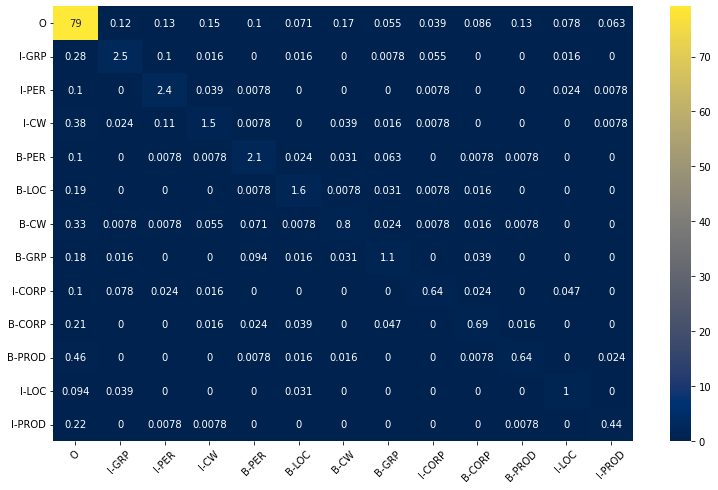

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

labels = list(lab2idx.keys())
labels.remove("<PAD>")

cf_matrix = confusion_matrix(flat_list(y_true_list), flat_list(y_pred_list), labels=labels)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*100, index = [i for i in labels],
                     columns = [i for i in labels])

accuracy = np.trace(cf_matrix) / np.sum(cf_matrix).astype('float')
misclass = 1 - accuracy

plt.figure(figsize = (13,8))
plt.xticks(np.arange(len(labels)), labels, rotation=45)

sn.heatmap(df_cm, annot=True, cmap="cividis")
# plt.savefig("confusion", dpi=300)

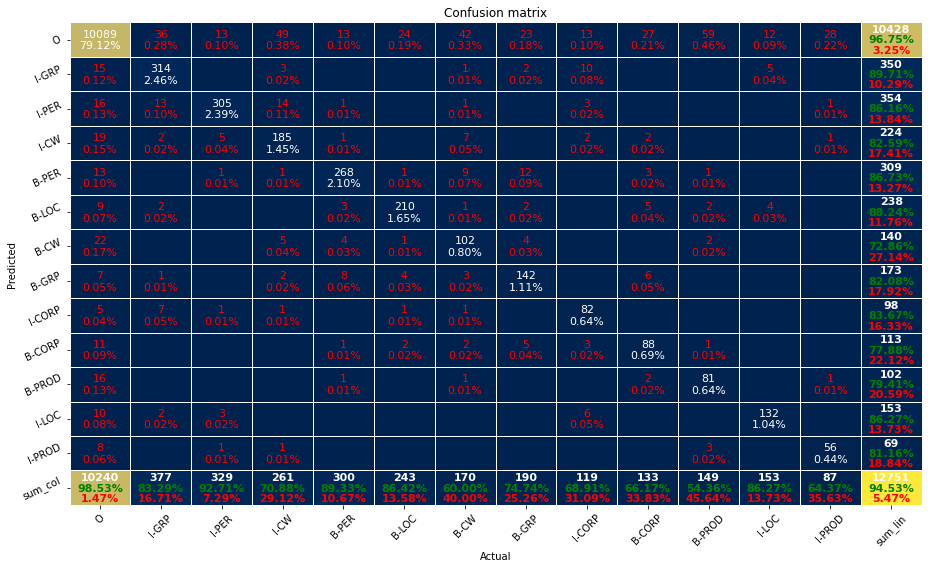

In [63]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from pretty_confusion_matrix import pp_matrix

labels = list(lab2idx.keys())
labels.remove("<PAD>")

cf_matrix = confusion_matrix(flat_list(y_true_list), flat_list(y_pred_list), labels=labels)

# Get pandas dataframe
df_cm = pd.DataFrame(cf_matrix, index = [i for i in labels],
                     columns = [i for i in labels])

# Colormap
cmap = 'PuRd'
# GnBu, YlGnBu
plot = pp_matrix(df_cm, cmap="cividis", figsize=(13,8), annot=True)

# Other Attempts

In this part are present the main attempts I have tried. Some portions of code are commented out because they were part of trials, thus you may find some code not very clean. In fact, I did not try to modularize much the code and for this reason you may find code repetitions.

## With POS

In [67]:
class NER_POS_Dataset(NER_Dataset):
    """
    Subclass of NER_Dataset where are also considered the POS tags.
    """
    def __init__(self, sentences: List[List[str]], sentences_labels: List[List[str]], sentences_pos: List[List[str]]):
        """
        Parameters
        ----------
        sentences: List[List[str]]
            A list of lists of strings where each nested list represents a sentence.

        sentences_labels: List[List[str]]
            A list of lists of strings where each nested list represents a sentence,
            containing the labels of the tokens.
        
        sentences_pos: List[List[str]]
            A list of lists of strings where each nested list represents a sentence,
            containing the POS tags of the tokens.
        """

        assert len(sentences) == len(sentences_labels) == len(sentences_pos), \
                "Inputs must be of the same length"

        super(NER_POS_Dataset, self).__init__(sentences, sentences_labels)
        
        self.Y = self._from_sequence_to_idx(sentences_labels, lab2idx)
        self.X = self._from_sequence_to_idx(sentences, vocab, unk_token)
        
        # POS
        self.pos = sentences_pos
        self.X_pos = self._from_sequence_to_idx(sentences_pos, pos2idx, pad_token)        

    def __getitem__(self, idx):
        return self.Y[idx], self.X[idx], self.sentences_lengths[idx], self.X_pos[idx]

In [68]:
train_dataset = NER_POS_Dataset(train_sentences, train_labels, train_pos)
valid_dataset = NER_POS_Dataset(valid_sentences, valid_labels, valid_pos)

In [69]:
def collate_batch(batch):
    """
    Returns
    -------
        Tensors of the zipped lists in input, sorted in
        descending order by sentences length.
        (The ordering can be useful if 'pack_padded_sequence'
        will be used)
        
    Parameters
    ----------
        batch
            A zipped python object containing features and labels.
    
    """
    labels_list = []
    features_list = []
    pos_features_list = []

    labels, features, sentences_lengths, pos_features = zip(*batch)
    
    sorted_batch = sorted(zip(labels, features, sentences_lengths, pos_features), 
                          key=lambda p: len(p[0]), reverse=True)
    labels, features, sentences_lengths, pos_features = zip(*sorted_batch)
        
    max_length_in_batch = np.max(sentences_lengths)
    
    # Pad sentences and labels to the length of the longest sequence in the batch
    for idx, feature in enumerate(features):
        features_list.append(pad_sequence(feature, max_length_in_batch, vocab[pad_token]))
        labels_list.append(pad_sequence(labels[idx], max_length_in_batch, lab2idx[pad_token]))
        pos_features_list.append(pad_sequence(pos_features[idx], max_length_in_batch, pos2idx[pad_token]))
      

    labels_tensor = torch.LongTensor(labels_list).to(device)
    features_tensor = torch.LongTensor(features_list).to(device)
    pos_features_tensor = torch.LongTensor(pos_features_list).to(device)

    return labels_tensor, features_tensor, sentences_lengths, pos_features_tensor

In [70]:
from TorchCRF import CRF
class NER_POS_Classifier(NER_Classifier):
    def __init__(self, h_params):
        super(NER_POS_Classifier, self).__init__(h_params)
        
        # POS embeddings
        self.embeddings_pos = nn.Embedding(h_params['pos_vocab_size'], 
                                            h_params['pos_embed_dim'],
                                            padding_idx=0)
        
        
#         self.lstm_pos = nn.LSTM(h_params['pos_embed_dim'], 
#                             h_params['pos_lstm_hidden_dim'], 
#                             bidirectional=h_params['bidirectional'],
# #                             num_layers=h_params['num_layers'],
#                             num_layers=2,
#                             dropout=h_params['dropout'] if h_params['num_layers'] > 1 else 0,
#                             batch_first=True)
        
        
#         pos_lstm_output_dim = h_params['pos_lstm_hidden_dim'] if h_params['bidirectional'] is False \
#                                 else h_params['pos_lstm_hidden_dim'] * 2
        
        
        lstm_input_dim = h_params['fast_embed_dim'] + h_params['glove_embed_dim'] + h_params['pos_embed_dim']
        
        # LSTM Word embeddings
        self.lstm = nn.LSTM(lstm_input_dim, 
                            h_params['lstm_hidden_dim'], 
                            bidirectional=h_params['bidirectional'],
                            num_layers=h_params['num_layers'],
                            dropout=h_params['dropout'] if h_params['num_layers'] > 1 else 0,
                            batch_first=True)
        
        
        lstm_output_dim = h_params['lstm_hidden_dim'] if h_params['bidirectional'] is False \
                            else h_params['lstm_hidden_dim'] * 2
        

        self.dropout = nn.Dropout(h_params['dropout'])  

        self.concat = nn.Linear(lstm_output_dim, lstm_output_dim)

#         self.fc1 = nn.Linear(lstm_output_dim, lstm_output_dim)

        self.classifier = nn.Linear(lstm_output_dim, h_params['num_classes'])
        
        self.relu = nn.LeakyReLU()
        
        if h_params['use_crf']:
            self.crf = CRF(h_params['num_classes'])

        self._init_linear_weights()
        
        
    def forward(self, x, x_lengths, x_pos):
        
#         x_pos = self.embeddings_pos(x_pos)
#         x_pos = self.dropout(x_pos)
        
#         x_pos = torch.nn.utils.rnn.pack_padded_sequence(x_pos, x_lengths, batch_first=True)
        
#         x_pos, _ = self.lstm_pos(x_pos)
#         x_pos, _ = torch.nn.utils.rnn.pad_packed_sequence(x_pos, padding_value=0, batch_first=True)
        
        x_pos = self.embeddings_pos(x_pos)
        
        x_fast = self.fast_embeddings(x)
        x_glove = self.glove_embeddings(x)
        
        x = torch.cat((x_fast, x_glove, x_pos), dim=2)  
        x = self.dropout(x)
        
        x, _ = self.lstm(x)
        x = self.relu(x)
        
        x = self.concat(x)
        x = self.relu(x)
#         x = self.fc1(x)

#         x = self.dropout(x)
        output = self.classifier(x)

        return output
    
    def _init_linear_weights(self):
        initrange = 0.5

        self.concat.weight.data.uniform_(-initrange, initrange)
        self.concat.bias.data.zero_()
        
#         self.fc1.weight.data.uniform_(-initrange, initrange)
#         self.fc1.bias.data.zero_()
        
        self.classifier.weight.data.uniform_(-initrange, initrange)
        self.classifier.bias.data.zero_()

## Training POS

In [71]:
def train(model: nn.Module, dataloader: DataLoader, h_params: dict, 
          optimizer: torch.optim, criterion: torch.nn, grad_clipping:float):
    model.train()    
    running_loss = 0.0
    viterbi_pred = None
    
    for idx, (labels, features, sentences_lengths, pos_features) in enumerate(dataloader): 
        # Empty gradients
        optimizer.zero_grad()

        # Forward
        predicted_labels = model(features, sentences_lengths, pos_features)

        
        if h_params['use_crf']:
            # Mask for extracting the actual length of the predictions,
            # as padding must be ignored
            mask = (labels != lab2idx[pad_token])
            
            log_likelihood = model.crf(predicted_labels, labels, mask=mask)
            # Predictions
            viterbi_pred = flat_list(model.crf.viterbi_decode(predicted_labels, mask=mask))        
                
                
            # The log likelihood is not "normalized" 
            # (It is not reduced, for instance by mean, and it is negative)
            loss = torch.mean(log_likelihood) * -1
            
        else:
            predicted_labels = predicted_labels.view(-1, predicted_labels.shape[-1])
            labels = labels.view(-1)
            loss = criterion(predicted_labels, labels)
            

         # Backward  
        loss.backward()
        
        # Gradient Clipping to prevent exploding gradients
        if grad_clipping is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clipping)
        
        # Update weights 
        optimizer.step()
        
        running_loss += loss.item()

    # Loss at the end of the epoch 
    return running_loss/len(dataloader), _

In [72]:
def evaluate(model: nn.Module, dataloader: DataLoader, 
             h_params: dict, criterion: torch.nn):
    model.eval()
    valid_loss = 0.0
    f1_score = 0.0
    viterbi_pred = None
    
    with torch.no_grad():
        for idx, (labels, features, sentences_lengths, pos_features) in enumerate(dataloader):
            predicted_labels = model(features, sentences_lengths, pos_features)
            
            if h_params['use_crf']:
                # Mask for extracting the actual length of the predictions,
                # as padding must be ignored
                mask = (labels != lab2idx[pad_token])
                log_likelihood = model.crf(predicted_labels, labels, mask=mask) 
                
                viterbi_pred = flat_list(model.crf.viterbi_decode(predicted_labels, mask=mask))                        
                
                # The log likelihood is not "normalized" 
                # (It is not reduced, for instance by mean, and it is negative)
                loss = torch.mean(log_likelihood) * -1

                predicted_labels = predicted_labels.view(-1, predicted_labels.shape[-1])
                labels = labels.view(-1)
                

            else:
                predicted_labels = predicted_labels.view(-1, predicted_labels.shape[-1])
                labels = labels.view(-1)
                loss = criterion(predicted_labels, labels)
                
               
            valid_loss += loss.item()
            f1_score += compute_score(predicted_labels, labels, viterbi_pred)
            
    return valid_loss/len(dataloader), f1_score/len(dataloader)

In [ ]:
# Hyperparameters
h_params = {
    'pos_vocab_size': len(pos2idx),
    'pos_embed_dim': 100,
    'pos_lstm_hidden_dim': 100,
    'vocab_size': len(vocab),
    'fast_embed_dim': 300,
    'freeze_fast': True,
    'glove_embed_dim': 100,
    'freeze_glove': False,
    'lstm_hidden_dim': 512, 
    'num_classes': len(lab2idx),
    'fast_embeddings': fast_pretrained_embeddings,
    'glove_embeddings': glove_pretrained_embeddings,
    'bidirectional': True,
    'num_layers': 2,
    'dropout': 0.3,
    'use_crf': True,  
}

epochs = 8 # number of epochs
lr = 0.003 # learning rate
bacth_size = 128 # batch size 
grad_clipping = 1.5 # for clipping gradients         
    

model = NER_POS_Classifier(h_params).to(device)
print(model)


                                            # ignore the padding class
criterion = torch.nn.CrossEntropyLoss(ignore_index=lab2idx[pad_token]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = None
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6, 9, 13, 20, 22], gamma=0.1)


train_dataloader = DataLoader(train_dataset, batch_size=bacth_size, 
                              collate_fn=collate_batch, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=bacth_size, 
                              collate_fn=collate_batch, shuffle=False)

histories = train_model(model, train_dataloader, valid_dataloader, h_params, 
                        optimizer, criterion, scheduler, grad_clipping, epochs,
                        early_stopping=True, early_stopping_mode="max", 
                        early_stopping_patience=2)

## With Char

In [74]:
class NER_CHAR_Dataset(NER_Dataset):
    """
    Subclass of NER_Dataset where are also considered Char emebeddings.
    """
    def __init__(self, sentences, sentences_labels):
        """
        Parameters
        ----------
        sentences: List[List[str]]
            A list of lists of strings where each nested list represents a sentence.

        sentences_labels: List[List[str]]
            A list of lists of strings where each nested list represents a sentence,
            containing the labels of the tokens.
        """

        assert len(sentences) == len(sentences_labels), \
                "Inputs must be of the same length"
        
        super(NER_CHAR_Dataset, self).__init__(sentences, sentences_labels)
        
        self.Y = self._from_sequence_to_idx(sentences_labels, lab2idx)
        self.X = self._from_sequence_to_idx(sentences, vocab, unk_token)
        
        # Chars
        self.tokens_lengths = [([len(token) for token in sentence]) for sentence in sentences]
        self.X_chars = self._from_tokens_to_char_idx(char_vocab, pad_token, unk_token)
        
    def _from_tokens_to_char_idx(self, vocab: dict, pad_token:str, unk_token: str) -> List[List[int]]:
        """
        Returns
        -------
            A list of lists of int built by replacing 
            each character in a token with its corresponding id in the vocabulary.

        Parameters
        ----------   
        vocab: dict
            The map that associates to each character an unique number.
        
        pad_token: str
            The Padding token.
        
        unk_token: str
            The OOV token.
        """
        sequences_idx = []
        
        for sentence in self.sentences:
            sequences_idx.append([[char_vocab.get(c, char_vocab[unk_token]) for c in token] 
                                     for token in sentence])
            
        return sequences_idx

    def __getitem__(self, idx):
        return self.Y[idx], self.X[idx], self.sentences_lengths[idx], self.X_chars[idx], self.tokens_lengths[idx]

In [75]:
train_dataset = NER_CHAR_Dataset(train_sentences, train_labels)
valid_dataset = NER_CHAR_Dataset(valid_sentences, valid_labels)

In [76]:
def collate_batch(batch):
    """
    Returns
    -------
        Tensors of the zipped lists in input, sorted in
        descending order by sentences length.
        (The ordering can be useful if 'pack_padded_sequence'
        will be used)
        
    Parameters
    ----------
        batch
            A zipped python object containing features and labels.
    """
    labels_list = []
    features_list = []
    char_features_list = []
 
    
    labels, features, sentences_lengths, char_features, tokens_lengths = zip(*batch)
    
    sorted_batch = sorted(zip(labels, features, sentences_lengths, char_features, tokens_lengths), 
                          key=lambda p: len(p[0]), reverse=True)
    labels, features, sentences_lengths, char_features, tokens_lengths = zip(*sorted_batch)

        
    max_length_in_batch = np.max(sentences_lengths)
    max_length_tokens = np.max(flat_list(tokens_lengths))
    
    
    # Pad sentences and labels to the length of the longest sequence in the batch
    for idx, feature in enumerate(features):
        features_list.append(pad_sequence(feature, max_length_in_batch, vocab[pad_token]))
        labels_list.append(pad_sequence(labels[idx], max_length_in_batch, vocab[pad_token]))
      
    
    for idx, sentence in enumerate(char_features): 
        chars_in_token = []
        for token in sentence:
            chars_in_token.append(
                                pad_sequence(token, max_length_tokens, char_vocab[pad_token])
                                )

        # Tensors must contain elemetns of the same shape,
        # therefore I add lists of zeros where the sentence
        # is smaller than 'max_length_in_batch'
        if len(chars_in_token) < max_length_in_batch:
            num_list_of_zeros = max_length_in_batch - len(chars_in_token)
            
            chars_in_token.extend([[char_vocab[pad_token]] * max_length_tokens] * num_list_of_zeros)

        char_features_list.append(chars_in_token)
 

    labels_tensor = torch.LongTensor(labels_list).to(device)
    features_tensor = torch.LongTensor(features_list).to(device)
    char_features_tensor = torch.LongTensor(char_features_list).to(device)
    tokens_lengths = torch.LongTensor([pad_sequence(s, max_length_in_batch, 1) 
                                       for s in tokens_lengths])
    
    return labels_tensor, features_tensor, sentences_lengths, char_features_tensor, tokens_lengths

I think there are some problems with the following implementation because it requires almost 10 minutes to run a single epoch on GPU. In theory, it should work as the training starts, nevertheless it takes too much time.

From `collate_batch` regarding character representation:
1. A sentence is a list of lists, where each nested list represents a token.
2. This token is composed by multiple characters, actually by the integer representation of that char taken from the *char_vocab*.

In Forward pass in `NER_CHAR_Classifier`:
1. In order to optimize a bit the computation I use the `pack_padded_sequence` method for RNNs. It packed data without considering the padding tokens, in this case zeros.
2. For that method the input is preferred to be already sorted in descending order by the token lengths; therefore in the first part of the forward pass I sorted the sentences to get first the sentence that have the longest tokens.
3. Then, I find an embedding for the tokens and I input them to a Bi-LSTM that should return the character representation.

Perhaps, I wrongly managed the number of zeros I inserted to pad both the sentences and the tokens in sentences in the `collate_batch` function, and this probably led to a exponentially increase of the running time.

In [221]:
from TorchCRF import CRF
class NER_CHAR_Classifier(NER_Classifier):
    def __init__(self, h_params):
        super(NER_CHAR_Classifier, self).__init__(h_params)
        

        # Char embeddings
        self.embeddings_char = nn.Embedding(h_params['char_vocab_size'], 
                                            h_params['char_embed_dim'],
                                            padding_idx=0)
        
        self.lstm_char = nn.LSTM(h_params['char_embed_dim'], 
                            h_params['char_lstm_hidden_dim'], 
                            bidirectional=h_params['bidirectional'],
                            num_layers=1,
                            batch_first=True)
        
        char_lstm_output_dim = h_params['char_lstm_hidden_dim'] if h_params['bidirectional'] is False \
                                else h_params['char_lstm_hidden_dim'] * 2
        
#         self.linear_char = nn.Linear(char_lstm_output_dim, char_lstm_output_dim)
        
        
        # Char + Word embeddings
        self.lstm = nn.LSTM(h_params['glove_embed_dim'] + char_lstm_output_dim, 
                            h_params['lstm_hidden_dim'], 
                            bidirectional=h_params['bidirectional'],
                            num_layers=h_params['num_layers'],
                            dropout=h_params['dropout'] if h_params['num_layers'] > 1 else 0,
                            batch_first=True)

        
        
        lstm_output_dim = h_params['lstm_hidden_dim'] if h_params['bidirectional'] is False \
                            else h_params['lstm_hidden_dim'] * 2
        

        self.dropout = nn.Dropout(h_params['dropout'])  
        
#         self.concat = nn.Linear(lstm_output_dim, lstm_output_dim)
#         self.concat2 = nn.Linear(lstm_output_dim, lstm_output_dim)

        self.classifier = nn.Linear(lstm_output_dim, h_params['num_classes'])
        
        self.relu = nn.LeakyReLU()
        if h_params['use_crf']:
            self.crf = CRF(h_params['num_classes'])

        self._init_linear_weights()


    def forward(self, x, x_lengths, x_char, x_char_lengths):
        batch_size = x_char.shape[0]
        sent_len = x_char.shape[1]
        
        # x_char.shape = batch_size x max_len_sentence x max_len_token 
        
        # Reshape = (batch_size * max_len_sentence) x max_len_token 
        x_char = x_char.view(batch_size * sent_len, -1) 
        
        # x_char_lengths.shape = batch_size x max_len_sentence
        
        # Reshape = (batch_size * max_len_sentence)
        x_char_lengths = x_char_lengths.view(batch_size * sent_len) 

        # Sort characters lengths in descending order
        sorted_seq_len, perm_idx = x_char_lengths.sort(0, descending=True)
        
        # It is important to be able to retrieve the non-sorted indices
        _, recover_idx = perm_idx.sort(0, descending=False)
        
        # Sort in descending order by lengths the char tensor  
        x_char = x_char[perm_idx]
        
        # x_char_emb.shape = (batch_size * max_len_sentence) x char_embed_dim
        x_char_emb = self.embeddings_char(x_char) 

        x_char_emb = self.dropout(x_char_emb)
        
        # Packed chars
        x_char_packed = torch.nn.utils.rnn.pack_padded_sequence(x_char_emb, sorted_seq_len, batch_first=True)

        x_char_lstm, _ = self.lstm_char(x_char_packed)
        
        # Retrieve the non packed tensor and the respective lengths
        x_char, x_char_lengths = torch.nn.utils.rnn.pad_packed_sequence(x_char_lstm, batch_first=True)
        
        # x_char.shape = (batch_size * max_len_sentence) x max_len_token x char_lstm_hidden_dim (* 2 if bidirect)
        
        # x_char_temp.shape = (batch_size * max_len_sentence) x char_lstm_hidden_dim (* 2 if bidirect)
        x_char_temp = torch.FloatTensor(torch.zeros((x_char.shape[0], x_char.shape[2]))).to(device)
        
        # Concatenate the last output of the forward LSTM 
        # and the last one of the reverse LSTM, obtaining a
        # second embedding for each word
        for i, index in enumerate(x_char_lengths):
            x_char_temp[i] = torch.cat((x_char[i, index-1, :h_params['char_lstm_hidden_dim']], 
                                        x_char[i, 0, h_params['char_lstm_hidden_dim']:]))

        
        # Reshape to the orginal non sorted positions
        x_char = x_char_temp[recover_idx]

        # Reshape to get the same dimensions as the word emb
        # x_char.shape =  batch_size x max_len_sentence x char_lstm_hidden_dim (* 2 if bidirect)
        x_char = x_char.view(batch_size, sent_len, -1)
          

        
#         x_char = self.linear_char(x_char)
#         x_char = self.relu(x_char)
    
        
#         x_fast = self.fast_embeddings(x)
        
        x_glove = self.glove_embeddings(x)
           

        x = torch.cat((x_char, x_glove), dim=2) 
        x = self.dropout(x)
        
        x, _ = self.lstm(x)
        
        x = self.relu(x)
        output = self.classifier(x)

        return output
    
    
    def _init_linear_weights(self):
        initrange = 0.5
#         self.linear_char.weight.data.uniform_(-initrange, initrange)
#         self.linear_char.bias.data.zero_()

#         self.concat.weight.data.uniform_(-initrange, initrange)
#         self.concat.bias.data.zero_()
#         self.concat2.weight.data.uniform_(-initrange, initrange)
#         self.concat2.bias.data.zero_()
        
        self.classifier.weight.data.uniform_(-initrange, initrange)
        self.classifier.bias.data.zero_()

## Training Char

In [222]:
def train(model: nn.Module, dataloader: DataLoader, h_params: dict, 
          optimizer: torch.optim, criterion: torch.nn, grad_clipping:float):
    model.train()    
    running_loss = 0.0
    viterbi_pred = None
    
    for idx, (labels, features, sentences_lengths, char_features, token_lenghts) in enumerate(dataloader): 
        # Empty gradients
        optimizer.zero_grad()

        # Forward
        predicted_labels = model(features, sentences_lengths, char_features, token_lenghts)

        
        if h_params['use_crf']:
            # Mask for extracting the actual length of the predictions,
            # as padding must be ignored
            mask = (labels != lab2idx[pad_token])
            
            log_likelihood = model.crf(predicted_labels, labels, mask=mask)
            # Predictions
            viterbi_pred = flat_list(model.crf.viterbi_decode(predicted_labels, mask=mask))        
                
                
            # The log likelihood is not "normalized" 
            # (It is not reduced, for instance by mean, and it is negative)
            loss = torch.mean(log_likelihood) * -1
            
        else:
            predicted_labels = predicted_labels.view(-1, predicted_labels.shape[-1])
            labels = labels.view(-1)
            loss = criterion(predicted_labels, labels)
            

         # Backward  
        loss.backward()
        
        # Gradient Clipping to prevent exploding gradients
        if grad_clipping is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clipping)
        
        # Update weights 
        optimizer.step()
        
        running_loss += loss.item()

    # Loss at the end of the epoch 
    return running_loss/len(dataloader), _

In [223]:
def evaluate(model: nn.Module, dataloader: DataLoader, 
             h_params: dict, criterion: torch.nn):
    model.eval()
    valid_loss = 0.0
    f1_score = 0.0
    viterbi_pred = None
    
    with torch.no_grad():
        for idx, (labels, features, sentences_lengths, char_features, token_lenghts) in enumerate(dataloader):
            predicted_labels = model(features, sentences_lengths, char_features, token_lenghts)
            
            if h_params['use_crf']:
                # Mask for extracting the actual length of the predictions,
                # as padding must be ignored
                mask = (labels != lab2idx[pad_token])
                log_likelihood = model.crf(predicted_labels, labels, mask=mask) 
                
                viterbi_pred = flat_list(model.crf.viterbi_decode(predicted_labels, mask=mask))                        
                
                # The log likelihood is not "normalized" 
                # (It is not reduced, for instance by mean, and it is negative)
                loss = torch.mean(log_likelihood) * -1

                predicted_labels = predicted_labels.view(-1, predicted_labels.shape[-1])
                labels = labels.view(-1)
                

            else:
                predicted_labels = predicted_labels.view(-1, predicted_labels.shape[-1])
                labels = labels.view(-1)
                loss = criterion(predicted_labels, labels)
                
               
            valid_loss += loss.item()
            f1_score += compute_score(predicted_labels, labels, viterbi_pred)
            
    return valid_loss/len(dataloader), f1_score/len(dataloader)

In [ ]:
# Hyperparameters
h_params = {
    'char_vocab_size': len(char_vocab),
    'char_embed_dim': 55,
    'char_lstm_hidden_dim': 50,
    'vocab_size': len(vocab),
    'fast_embed_dim': 300,
    'freeze_fast': True,
    'glove_embed_dim': 100,
    'freeze_glove': False,
    'lstm_hidden_dim': 256, 
    'num_classes': len(lab2idx),
    'fast_embeddings': fast_pretrained_embeddings,
    'glove_embeddings': glove_pretrained_embeddings,
    'bidirectional': True,
    'num_layers': 2,
    'dropout': 0.3,
    'use_crf': False, 
}

epochs = 20 # number of epochs
lr = 0.003 # learning rate 
bacth_size = 512 # batch size
grad_clipping = 2.15 # for clipping gradients

model = NER_CHAR_Classifier(h_params).to(device)
print(model)
    
                                            # ignore the padding class
criterion = torch.nn.CrossEntropyLoss(ignore_index=lab2idx[pad_token]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = None
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)         
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 9,], gamma=0.3)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.002, max_lr=0.01)

train_dataloader = DataLoader(train_dataset, batch_size=bacth_size, 
                              collate_fn=collate_batch, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=bacth_size, 
                              collate_fn=collate_batch, shuffle=False)

histories = train_model(model, train_dataloader, valid_dataloader, h_params, 
                        optimizer, criterion, scheduler, grad_clipping, epochs,
                        early_stopping=True, early_stopping_mode="max", 
                        early_stopping_patience=2)

## With POS and DEP

In [81]:
class NER_DEP_Dataset(NER_Dataset):
    """
    Subclass of NER_Dataset where are also considered Char emebeddings.
    """
    def __init__(self, sentences, sentences_labels, sentences_heads, sentences_dep):
        """
        Parameters
        ----------
        sentences: List[List[str]]
            A list of lists of strings where each nested list represents a sentence.

        sentences_labels: List[List[str]]
            A list of lists of strings where each nested list represents a sentence,
            containing the labels of the tokens.
        
        sentences_heads: List[List[str]]
            A list of lists of strings where each nested list represents a sentence,
            containing the token parents in the dependency tree.
        
        sentences_dep: List[List[str]]
            A list of lists of strings where each nested list represents a sentence,
            containing the dependency tag of the tokens.
        """

        assert len(sentences) == len(sentences_labels) == len(sentences_dep), \
                "Inputs must be of the same length"
        
        super(NER_DEP_Dataset, self).__init__(sentences, sentences_labels)

        self.Y = self._from_sequence_to_idx(sentences_labels, lab2idx)
        self.X = self._from_sequence_to_idx(sentences, vocab, unk_token)
        
        # DEP
        self.heads = sentences_heads
        self.dep = sentences_dep
        self.X_heads = self._from_sequence_to_idx(sentences_heads, vocab, unk_token)
        self.X_dep = self._from_sequence_to_idx(sentences_dep, dep_vocab, unk_token)

    def __getitem__(self, idx):
        return self.Y[idx], self.X[idx], self.sentences_lengths[idx], self.X_heads[idx], self.X_dep[idx]

In [82]:
train_dataset = NER_DEP_Dataset(train_sentences, train_labels, train_heads, train_dep)
valid_dataset = NER_DEP_Dataset(valid_sentences, valid_labels, valid_heads, valid_dep)

In [236]:
def collate_batch(batch):
    """
    Returns
    -------
        Tensors of the zipped lists in input, sorted in
        descending order by sentences length.
        (The ordering can be useful if 'pack_padded_sequence'
        will be used)
        
    Parameters
    ----------
        batch
            A zipped python object containing features and labels.
    """
    labels_list = []
    features_list = []
    heads_features_list = []
    dep_features_list = []

    labels, features, sentences_lengths, heads_features, dep_features = zip(*batch)
    
    sorted_batch = sorted(zip(labels, features, sentences_lengths, heads_features, dep_features), 
                          key=lambda p: len(p[0]), reverse=True)
    labels, features, sentences_lengths, heads_features, dep_features = zip(*sorted_batch)
        
    max_length_in_batch = np.max(sentences_lengths)
    
    # Pad sentences and labels to the length of the longest sequence in the batch
    for idx, feature in enumerate(features):
        features_list.append(pad_sequence(feature, max_length_in_batch, vocab[pad_token]))
        labels_list.append(pad_sequence(labels[idx], max_length_in_batch, lab2idx[pad_token]))
        heads_features_list.append(pad_sequence(heads_features[idx], max_length_in_batch, vocab[pad_token]))
        dep_features_list.append(pad_sequence(dep_features[idx], max_length_in_batch, dep_vocab[pad_token]))
        

    labels_tensor = torch.LongTensor(labels_list).to(device)
    features_tensor = torch.LongTensor(features_list).to(device)
    dep_features_tensor = torch.LongTensor(dep_features_list).to(device)
    heads_features_tensor = torch.LongTensor(heads_features_list).to(device)
   

    return labels_tensor, features_tensor, sentences_lengths, heads_features_tensor, dep_features_tensor

In [237]:
from TorchCRF import CRF
class NER_DEP_Classifier(NER_Classifier):
    def __init__(self, h_params):
        super(NER_DEP_Classifier, self).__init__(h_params)

        
#         self.lstm_pos_dep = nn.LSTM(h_params['pos_embed_dim'] + h_params['dep_embed_dim'], 
#                             h_params['pos_dep_lstm_hidden_dim'], 
#                             bidirectional=h_params['bidirectional'],
# #                             num_layers=h_params['num_layers'],
#                             num_layers=2,
#                             dropout=h_params['dropout'] if h_params['num_layers'] > 1 else 0,
#                             batch_first=True)
        
        
#         pos_dep_lstm_output_dim = h_params['pos_dep_lstm_hidden_dim'] if h_params['bidirectional'] is False \
#                                 else h_params['pos_dep_lstm_hidden_dim'] * 2
        
        # Dependency embeddings
        self.embeddings_dep = nn.Embedding(h_params['dep_vocab_size'], 
                                            h_params['dep_embed_dim'],
                                            padding_idx=0)

        lstm_input_dim = h_params['fast_embed_dim'] * 2 + h_params['glove_embed_dim'] * 2 + h_params['dep_embed_dim']
        
        # LSTM Word embeddings
        self.lstm = nn.LSTM(lstm_input_dim, 
                            h_params['lstm_hidden_dim'], 
                            bidirectional=h_params['bidirectional'],
                            num_layers=h_params['num_layers'],
                            dropout=h_params['dropout'] if h_params['num_layers'] > 1 else 0,
                            batch_first=True)
        
        
        lstm_output_dim = h_params['lstm_hidden_dim'] if h_params['bidirectional'] is False \
                            else h_params['lstm_hidden_dim'] * 2
        

        self.dropout = nn.Dropout(h_params['dropout'])  

        self.concat = nn.Linear(lstm_output_dim, lstm_output_dim)
#         self.fc1 = nn.Linear(self.lstm_output_dim, self.lstm_output_dim // 2)
#         self.fc2 = nn.Linear(self.lstm_output_dim //2, self.lstm_output_dim // 4)

        self.classifier = nn.Linear(lstm_output_dim, h_params['num_classes'])
        
        self.relu = nn.LeakyReLU()
        
        if h_params['use_crf']:
            self.crf = CRF(h_params['num_classes'])

        self._init_linear_weights()
        
        
    def forward(self, x, x_lengths, x_heads, x_dep):
        
        x_fast = self.fast_embeddings(x)
        x_glove = self.glove_embeddings(x)
        
        x_fast_heads = self.fast_embeddings(x_heads)
        x_glove_heads = self.glove_embeddings(x_heads)
        
        x_dep = self.embeddings_dep(x_dep)
        
        
        x = torch.cat((x_fast, x_glove, x_fast_heads, x_glove_heads, x_dep), dim=2)  
        x = self.dropout(x)
        
        x, _ = self.lstm(x)
        x = self.relu(x)
        
        x = self.concat(x)
        x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.relu(x)

        output = self.classifier(x)

        return output

    def _init_linear_weights(self):
        initrange = 0.5

#         self.concat.weight.data.uniform_(-initrange, initrange)
#         self.concat.bias.data.zero_()
#         self.fc1.weight.data.uniform_(-initrange, initrange)
#         self.fc1.bias.data.zero_()
#         self.fc2.weight.data.uniform_(-initrange, initrange)
#         self.fc2.bias.data.zero_()

        
        self.classifier.weight.data.uniform_(-initrange, initrange)
        self.classifier.bias.data.zero_()

## Training DEP

In [238]:
def train(model: nn.Module, dataloader: DataLoader, h_params: dict, 
          optimizer: torch.optim, criterion: torch.nn, grad_clipping:float):
    model.train()    
    running_loss = 0.0
    viterbi_pred = None
    
    for idx, (labels, features, sentences_lengths, heads_features, dep_features) in enumerate(dataloader): 
        # Empty gradients
        optimizer.zero_grad()

        # Forward
        predicted_labels = model(features, sentences_lengths, heads_features, dep_features)

        
        if h_params['use_crf']:
            # Mask for extracting the actual length of the predictions,
            # as padding must be ignored
            mask = (labels != lab2idx[pad_token])
            
            log_likelihood = model.crf(predicted_labels, labels, mask=mask)
            # Predictions
            viterbi_pred = flat_list(model.crf.viterbi_decode(predicted_labels, mask=mask))        
                
                
            # The log likelihood is not "normalized" 
            # (It is not reduced, for instance by mean, and it is negative)
            loss = torch.mean(log_likelihood) * -1
            
        else:
            predicted_labels = predicted_labels.view(-1, predicted_labels.shape[-1])
            labels = labels.view(-1)
            loss = criterion(predicted_labels, labels)
            

         # Backward  
        loss.backward()
        
        # Gradient Clipping to prevent exploding gradients
        if grad_clipping is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clipping)
        
        # Update weights 
        optimizer.step()
        
        running_loss += loss.item()

    # Loss at the end of the epoch 
    return running_loss/len(dataloader), _

In [239]:
def evaluate(model: nn.Module, dataloader: DataLoader, 
             h_params: dict, criterion: torch.nn):
    model.eval()
    valid_loss = 0.0
    f1_score = 0.0
    viterbi_pred = None
    
    with torch.no_grad():
        for idx, (labels, features, sentences_lengths, heads_features, dep_features) in enumerate(dataloader):
            predicted_labels = model(features, sentences_lengths, heads_features, dep_features)
            
            if h_params['use_crf']:
                # Mask for extracting the actual length of the predictions,
                # as padding must be ignored
                mask = (labels != lab2idx[pad_token])
                log_likelihood = model.crf(predicted_labels, labels, mask=mask) 
                
                viterbi_pred = flat_list(model.crf.viterbi_decode(predicted_labels, mask=mask))                        
                
                # The log likelihood is not "normalized" 
                # (It is not reduced, for instance by mean, and it is negative)
                loss = torch.mean(log_likelihood) * -1

                predicted_labels = predicted_labels.view(-1, predicted_labels.shape[-1])
                labels = labels.view(-1)
                

            else:
                predicted_labels = predicted_labels.view(-1, predicted_labels.shape[-1])
                labels = labels.view(-1)
                loss = criterion(predicted_labels, labels)
                
               
            valid_loss += loss.item()
            f1_score += compute_score(predicted_labels, labels, viterbi_pred)
            
    return valid_loss/len(dataloader), f1_score/len(dataloader)

In [241]:
# Hyperparameters
h_params = {
#     'pos_vocab_size': len(pos2idx),
#     'pos_embed_dim': 100,
#     'pos_dep_lstm_hidden_dim': 200,
    'dep_vocab_size': len(dep_vocab),
    'dep_embed_dim': 50,
    'vocab_size': len(vocab),
    'fast_embed_dim': 300,
    'freeze_fast': True,
    'glove_embed_dim': 100,
    'freeze_glove': False,
    'lstm_hidden_dim': 512, 
    'num_classes': len(lab2idx),
    'fast_embeddings': fast_pretrained_embeddings,
    'glove_embeddings': glove_pretrained_embeddings,
    'bidirectional': True,
    'num_layers': 3,
    'dropout': 0.4,
    'use_crf': True,  # set to true to test with the Conditional Random Field
}

epochs = 15 # number of epochs
lr = 0.003 # learning rate 
bacth_size = 128 # batch size 
grad_clipping = 0.7 # for clipping gradients   

model = NER_DEP_Classifier(h_params).to(device)
print(model)

                                            # ignore the padding class
criterion = torch.nn.CrossEntropyLoss(ignore_index=lab2idx[pad_token]).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.95)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = None
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6, 9, 13, 20, 22], gamma=0.1)


train_dataloader = DataLoader(train_dataset, batch_size=bacth_size, 
                              collate_fn=collate_batch, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=bacth_size, 
                              collate_fn=collate_batch, shuffle=False)

histories = train_model(model, train_dataloader, valid_dataloader, h_params, 
                        optimizer, criterion, scheduler, grad_clipping, epochs,
                        early_stopping=True, early_stopping_mode="max", 
                        early_stopping_patience=2)

NER_DEP_Classifier(
  (fast_embeddings): Embedding(20000, 300, padding_idx=0)
  (glove_embeddings): Embedding(20000, 100, padding_idx=0)
  (lstm): LSTM(850, 512, num_layers=3, batch_first=True, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (concat): Linear(in_features=1024, out_features=1024, bias=True)
  (classifier): Linear(in_features=1024, out_features=14, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (crf): CRF()
  (embeddings_dep): Embedding(47, 50, padding_idx=0)
)
LR: 0.003000
----------------------------------------------------------------------------------------------------
| epoch   1/15 | time: 35.37s | train_loss: 10.461 | valid_loss: 4.789 | valid_f1_score: 0.480
----------------------------------------------------------------------------------------------------
LR: 0.003000
----------------------------------------------------------------------------------------------------
| epoch   2/15 | time: 35.41s | train_loss: 3.666 | valid_l